이 데이터 세트는 비침습적 혈압 예측에 사용되는 MIMIC-III 데이터 세트의 하위 집합입니다. PPG 및 ABP 데이터는 7초 길이의 윈도우(875개 데이터 포인트)로 나뉩니다. 수축기 및 이완기 혈압 값은 ABP 윈도우에서 파생되었습니다. 데이터 세트의 각 샘플은 PPG 신호와 혈압 값, 그리고 고유한 피험자 식별자로 구성됩니다. 이 파일은 세 개의 데이터 세트로 구성됩니다.

PPG: 905,400 x 875 크기의 PPG 데이터
레이블: 905,400 x 2 크기의 BP 데이터
subject_idx: 각 샘플의 피험자 소속(크기 905,400 x 1)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input, Model

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D, GRU
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation, UpSampling1D
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.layers import add, multiply, GlobalAveragePooling1D
from sklearn.linear_model import LinearRegression

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from keras import  backend as K
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


2024-08-18 14:47:16.455018: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 14:47:16.455105: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 14:47:16.455132: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-18 14:47:16.463151: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import h5py

# 잠금 없이 파일 열기
with h5py.File('MIMIC-III_ppg_dataset.h5', 'r', locking=False) as f:
    dataset_names = list(f.keys())
    print("Available datasets:", dataset_names)

Available datasets: ['label', 'ppg', 'subject_idx']


In [3]:
# .h5 파일 열기
with h5py.File('MIMIC-III_ppg_dataset.h5', 'r', locking=False) as f:
    # 특정 데이터셋 불러오기 (예: 'label' 데이터셋)
    data_label = f['label'][:]
    data_ppg = f['ppg'][:]
    data_subject_idx = f['subject_idx'][:]
    
    print(data_label)
    print(data_ppg)
    print(data_subject_idx)

[[ 98  57]
 [100  56]
 [115  60]
 ...
 [143  66]
 [119  63]
 [146  74]]
[[-0.5025518  -0.5326032  -0.5624843  ... -0.28123745 -0.27767116
  -0.2727553 ]
 [-0.32402784 -0.3677722  -0.41105923 ...  0.660843    0.5616221
   0.4570674 ]
 [ 0.0789502  -0.02330504 -0.12383569 ... -0.04361962 -0.03981035
  -0.03410682]
 ...
 [-0.22356206 -0.27264422 -0.32297283 ... -0.0673175  -0.06447504
  -0.06026017]
 [-0.03491007 -0.1202258  -0.20588434 ...  0.28017786  0.28330782
   0.2905485 ]
 [ 0.38536417  0.43365255  0.48704892 ... -0.30071005 -0.29895812
  -0.2964506 ]]
[[   0]
 [   0]
 [   0]
 ...
 [4554]
 [4554]
 [4554]]


In [4]:
print(data_label.shape)
print(data_ppg.shape)
print(data_subject_idx)

(9054000, 2)
(9054000, 875)
[[   0]
 [   0]
 [   0]
 ...
 [4554]
 [4554]
 [4554]]


data_label 값 중 앞부분은 수축기 혈압(SBP), 뒷 부분은 이완기 혈압(DBP)

In [5]:
# 각각의 데이터를 DataFrame으로 변환
df_label = pd.DataFrame(data_label, columns=['SBP', 'DBP'])
df_ppg = pd.DataFrame(data_ppg)
df_subject_idx = pd.DataFrame(data_subject_idx, columns=['subject_idx'])

In [6]:
# 세 개의 DataFrame을 하나로 합치기
df = pd.concat([df_subject_idx, df_label, df_ppg], axis=1)

# 결과 확인
print(df.head())

   subject_idx  SBP  DBP         0         1         2         3         4  \
0            0   98   57 -0.502552 -0.532603 -0.562484 -0.591756 -0.620017   
1            0  100   56 -0.324028 -0.367772 -0.411059 -0.453427 -0.494457   
2            0  115   60  0.078950 -0.023305 -0.123836 -0.221000 -0.313295   
3            0   83   55  0.233394  0.251590  0.267639  0.279521  0.285665   
4            0  109   58 -0.173036 -0.190641 -0.208551 -0.226650 -0.244931   

          5         6  ...       865       866       867       868       869  \
0 -0.646934 -0.672269  ... -0.257694 -0.267066 -0.274259 -0.279373 -0.282512   
1 -0.533794 -0.571164  ...  1.077976  1.055641  1.019408  0.970138  0.908652   
2 -0.399417 -0.478317  ... -0.012682 -0.025805 -0.034969 -0.040991 -0.044514   
3  0.285092  0.277481  ... -0.217937 -0.226153 -0.233065 -0.238201 -0.241181   
4 -0.263568 -0.282928  ... -0.305273 -0.304013 -0.303961 -0.304851 -0.306394   

        870       871       872       873       87

In [7]:
# 슬라이싱을 통해 상위 5만 개의 rows 선택
df = df[:20000]

In [8]:
'''# 데이터 샘플링 (예: 10%)
df_sample = df.sample(frac=0.1, random_state=42)

# 특징과 타겟 설정
features = df_sample.drop(['subject_idx', 'SBP', 'DBP'], axis=1)
target_sbp = df_sample['SBP']
target_dbp = df_sample['DBP']
'''

"# 데이터 샘플링 (예: 10%)\ndf_sample = df.sample(frac=0.1, random_state=42)\n\n# 특징과 타겟 설정\nfeatures = df_sample.drop(['subject_idx', 'SBP', 'DBP'], axis=1)\ntarget_sbp = df_sample['SBP']\ntarget_dbp = df_sample['DBP']\n"

In [9]:
# 특징(features)과 타겟(target) 변수 설정
features = df.drop(['subject_idx', 'SBP', 'DBP'], axis=1)  # 'subject_idx', 'SBP', 'DBP'를 제외한 나머지가 특징
target_sbp = df['SBP']  # SBP 예측
target_dbp = df['DBP']  # DBP 예측

In [10]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [11]:
TIME_STEPS = 200
STEP = 40

In [12]:
X_sbp, y_sbp = create_dataset(features, target_sbp, TIME_STEPS,STEP)
X_dbp, y_dbp = create_dataset(features, target_dbp, TIME_STEPS,STEP)

In [13]:
# 학습 데이터와 테스트 데이터로 분리
from sklearn.model_selection import train_test_split
X_train_sbp, X_test_sbp, y_train_sbp, y_test_sbp = train_test_split(X_sbp, y_sbp, test_size=0.2, random_state=42)
X_train_dbp, X_test_dbp, y_train_dbp, y_test_dbp = train_test_split(X_dbp, y_dbp, test_size=0.2, random_state=42)

In [14]:
X_train_sbp, X_val_sbp, y_train_sbp, y_val_sbp = train_test_split(X_train_sbp, y_train_sbp, test_size=0.2, random_state=42)
X_train_dbp, X_val_dbp, y_train_dbp, y_val_dbp = train_test_split(X_train_dbp, y_train_dbp, test_size=0.2, random_state=42)

In [15]:
print(X_train_sbp)
print(y_train_sbp)
print(X_train_sbp.shape)
print(y_train_sbp.shape)

[[[-0.08734079  0.14538272  0.37616134 ... -0.30338317 -0.30026004
   -0.29651207]
  [-0.13399865 -0.15464634 -0.17522067 ...  0.347568    0.25832617
    0.16656649]
  [-0.06255069  0.17568322  0.40280938 ... -0.24734193 -0.15508166
   -0.0672254 ]
  ...
  [-0.03528887 -0.06097228 -0.08514317 ... -0.305176   -0.26782784
   -0.2275739 ]
  [ 0.01653224  0.15638548  0.30133954 ...  0.40812045  0.21469696
    0.01111817]
  [ 0.3191376   0.3829499   0.4549099  ... -0.6957228  -0.4991984
   -0.29387897]]

 [[ 0.19069411  0.06652807 -0.05708411 ...  0.3940342   0.35005113
    0.30836785]
  [ 0.2566164   0.23312461  0.20953959 ... -0.05851342 -0.07184143
   -0.08243753]
  [-0.4881514  -0.58252937 -0.67660105 ... -0.04621337 -0.05946529
   -0.07034957]
  ...
  [-0.16160634 -0.00217425  0.14916842 ...  0.4995185   0.43106964
    0.3618249 ]
  [ 0.23093337  0.14490356  0.06098947 ... -0.5001771  -0.33043694
   -0.1510811 ]
  [ 0.0687525  -0.0395284  -0.14987448 ... -0.15087934 -0.12727891
   -0.0

In [16]:
n_timesteps,n_features,n_outputs= X_train_sbp.shape[1],X_train_sbp.shape[2],y_train_sbp.shape[1]

In [17]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [18]:
"""
The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.
"""


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    # input_shape 튜플 풀기
    n_steps, n_features = input_shape
    
    inputs = keras.Input(shape=(n_steps, n_features))
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    # 회귀를 위한 출력 레이어
    outputs = layers.Dense(1, activation="linear")(x)
    return keras.Model(inputs, outputs)

In [19]:
"""
## Train and evaluate
"""

input_shape = X_train_sbp.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

2024-08-18 14:48:59.882894: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:88:00.0, compute capability: 8.0
2024-08-18 14:48:59.885266: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:8c:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 875)]           0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 200, 875)             3587947   ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 200, 875)             0         ['multi_head_attention[0][0]']
                                                                                                  
 layer_normalization (Layer  (None, 200, 875)             1750      ['dropout[0][0]']         

 tf.__operators__.add_5 (TF  (None, 200, 875)             0         ['layer_normalization_5[0][0]'
 OpLambda)                                                          , 'tf.__operators__.add_4[0][0
                                                                    ]']                           
                                                                                                  
 multi_head_attention_3 (Mu  (None, 200, 875)             3587947   ['tf.__operators__.add_5[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'tf.__operators__.add_5[0][0]
                                                                    ']                            
                                                                                                  
 dropout_6 (Dropout)         (None, 200, 875)             0         ['multi_head_attention_3[0][0]
          

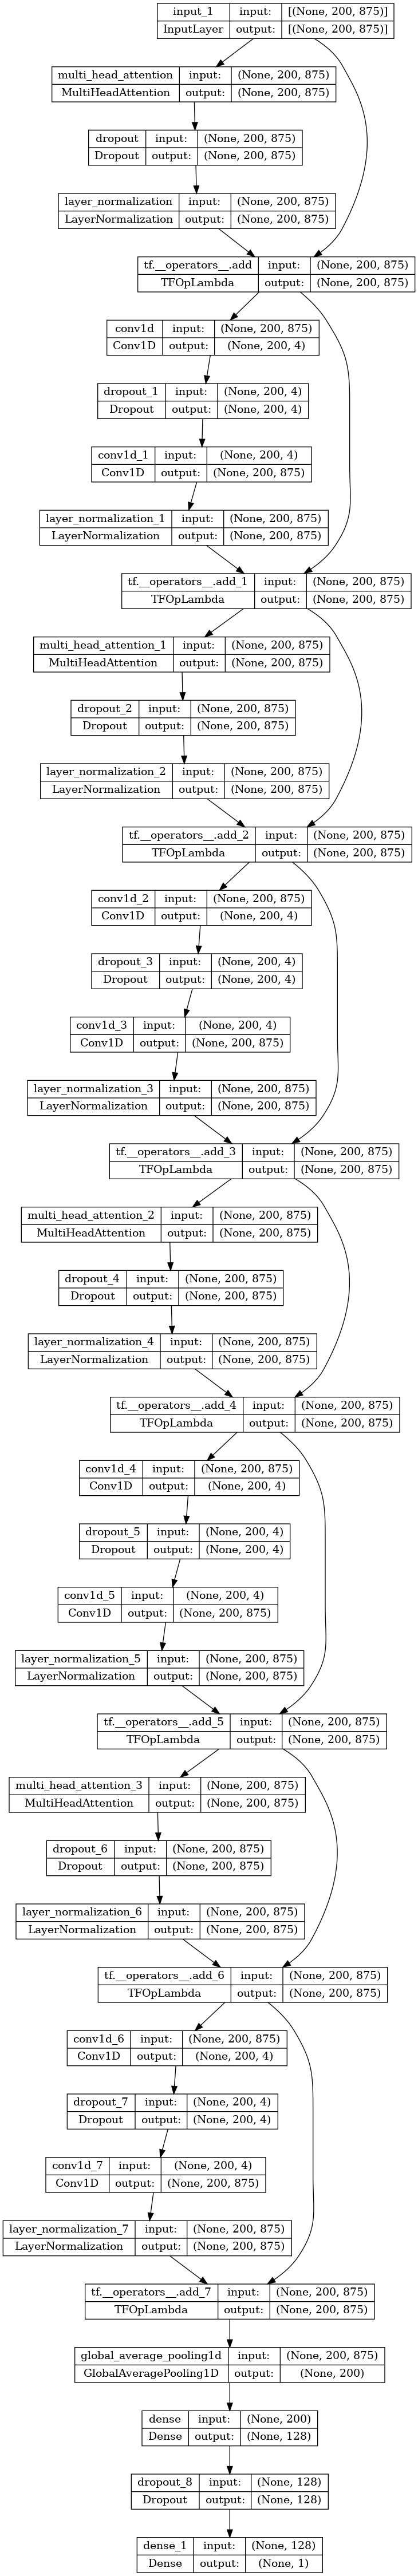

In [20]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [21]:
history = model.fit(
    X_train_sbp,
    y_train_sbp,
    validation_data=(X_val_sbp, y_val_sbp),
    epochs=300,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(X_test_sbp, y_test_sbp, verbose=1)

Epoch 1/300


2024-08-18 14:49:07.634479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-08-18 14:49:08.086295: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe34e9a2970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-18 14:49:08.086347: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-08-18 14:49:08.086354: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-08-18 14:49:08.092038: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-18 14:49:08.180362: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 [==============================] - 12s 274ms/step - loss: 13457.0977 - mean_squared_error: 13457.0977 - val_loss: 13688.3076 - val_mean_squared_error: 13688.3076
Epoch 2/300
5/5 [==============================] - 1s 107ms/step - loss: 13452.1768 - mean_squared_error: 13452.1768 - val_loss: 13681.4795 - val_mean_squared_error: 13681.4795
Epoch 3/300
5/5 [==============================] - 1s 112ms/step - loss: 13444.8926 - mean_squared_error: 13444.8926 - val_loss: 13671.9092 - val_mean_squared_error: 13671.9092
Epoch 4/300
5/5 [==============================] - 1s 107ms/step - loss: 13434.6328 - mean_squared_error: 13434.6328 - val_loss: 13659.4502 - val_mean_squared_error: 13659.4502
Epoch 5/300
5/5 [==============================] - 1s 116ms/step - loss: 13421.9033 - mean_squared_error: 13421.9033 - val_loss: 13643.6143 - val_mean_squared_error: 13643.6143
Epoch 6/300
5/5 [==============================] - 1s 111ms/step - loss: 13405.2881 - mean_squared_error: 13405.2881 - val_los

5/5 [==============================] - 0s 105ms/step - loss: 8401.4531 - mean_squared_error: 8401.4531 - val_loss: 8194.4209 - val_mean_squared_error: 8194.4209
Epoch 48/300
5/5 [==============================] - 1s 110ms/step - loss: 8171.0825 - mean_squared_error: 8171.0825 - val_loss: 7960.3345 - val_mean_squared_error: 7960.3345
Epoch 49/300
5/5 [==============================] - 1s 108ms/step - loss: 7894.7358 - mean_squared_error: 7894.7358 - val_loss: 7719.0850 - val_mean_squared_error: 7719.0850
Epoch 50/300
5/5 [==============================] - 1s 109ms/step - loss: 7668.6226 - mean_squared_error: 7668.6226 - val_loss: 7480.8564 - val_mean_squared_error: 7480.8564
Epoch 51/300
5/5 [==============================] - 1s 109ms/step - loss: 7452.1362 - mean_squared_error: 7452.1362 - val_loss: 7247.4912 - val_mean_squared_error: 7247.4912
Epoch 52/300
5/5 [==============================] - 1s 115ms/step - loss: 7239.8237 - mean_squared_error: 7239.8237 - val_loss: 7003.1807 - val

5/5 [==============================] - 0s 105ms/step - loss: 796.7391 - mean_squared_error: 796.7391 - val_loss: 540.0676 - val_mean_squared_error: 540.0676
Epoch 95/300
5/5 [==============================] - 1s 107ms/step - loss: 853.6603 - mean_squared_error: 853.6603 - val_loss: 509.9499 - val_mean_squared_error: 509.9499
Epoch 96/300
5/5 [==============================] - 0s 103ms/step - loss: 788.4254 - mean_squared_error: 788.4254 - val_loss: 482.2357 - val_mean_squared_error: 482.2357
Epoch 97/300
5/5 [==============================] - 1s 107ms/step - loss: 777.4258 - mean_squared_error: 777.4258 - val_loss: 459.6051 - val_mean_squared_error: 459.6051
Epoch 98/300
5/5 [==============================] - 0s 104ms/step - loss: 696.5126 - mean_squared_error: 696.5126 - val_loss: 438.9497 - val_mean_squared_error: 438.9497
Epoch 99/300
5/5 [==============================] - 0s 105ms/step - loss: 673.1288 - mean_squared_error: 673.1288 - val_loss: 420.1448 - val_mean_squared_error: 42

5/5 [==============================] - 0s 98ms/step - loss: 397.5084 - mean_squared_error: 397.5084 - val_loss: 189.2407 - val_mean_squared_error: 189.2407
Epoch 143/300
5/5 [==============================] - 0s 99ms/step - loss: 407.2463 - mean_squared_error: 407.2463 - val_loss: 184.4896 - val_mean_squared_error: 184.4896
Epoch 144/300
5/5 [==============================] - 0s 99ms/step - loss: 412.5967 - mean_squared_error: 412.5967 - val_loss: 178.3013 - val_mean_squared_error: 178.3013
Epoch 145/300
5/5 [==============================] - 1s 106ms/step - loss: 334.4907 - mean_squared_error: 334.4907 - val_loss: 172.3049 - val_mean_squared_error: 172.3049
Epoch 146/300
5/5 [==============================] - 0s 100ms/step - loss: 384.8093 - mean_squared_error: 384.8093 - val_loss: 172.3479 - val_mean_squared_error: 172.3479
Epoch 147/300
5/5 [==============================] - 1s 108ms/step - loss: 423.1614 - mean_squared_error: 423.1614 - val_loss: 174.7350 - val_mean_squared_error: 

[207.6402130126953, 207.6402130126953]

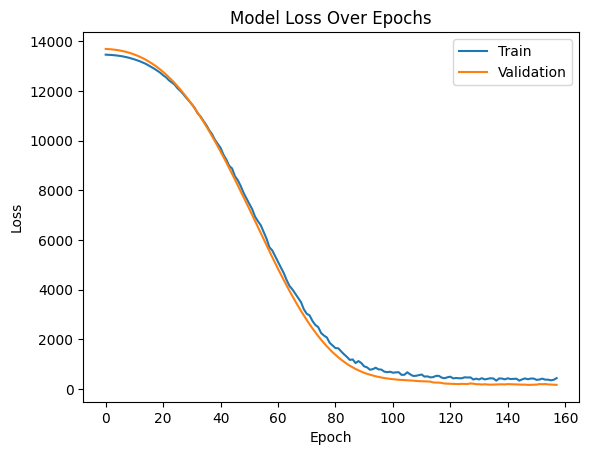

In [22]:

# 학습 손실 (Training Loss)
plt.plot(history.history['loss'])
# 검증 손실 (Validation Loss)
plt.plot(history.history['val_loss'])

# 그래프 제목 및 축 레이블 설정
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# 범례 추가
plt.legend(['Train', 'Validation'], loc='upper right')

# 그래프 출력
plt.show()

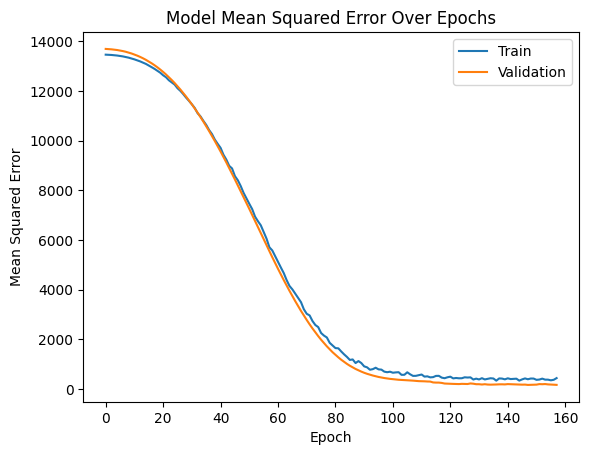

In [23]:
# 학습 손실 (Training Loss: Mean Squared Error)
plt.plot(history.history['mean_squared_error'])
# 검증 손실 (Validation Loss: Mean Squared Error)
plt.plot(history.history['val_mean_squared_error'])

# 그래프 제목 및 축 레이블 설정
plt.title('Model Mean Squared Error Over Epochs')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')

# 범례 추가
plt.legend(['Train', 'Validation'], loc='upper right')

# 그래프 출력
plt.show()

4/4 [==============================] - 0s 15ms/step
Mean Squared Error (MSE): 207.64020542693243
Mean Absolute Error (MAE): 10.812279672333688
R-squared (R²): 0.3762270658808472


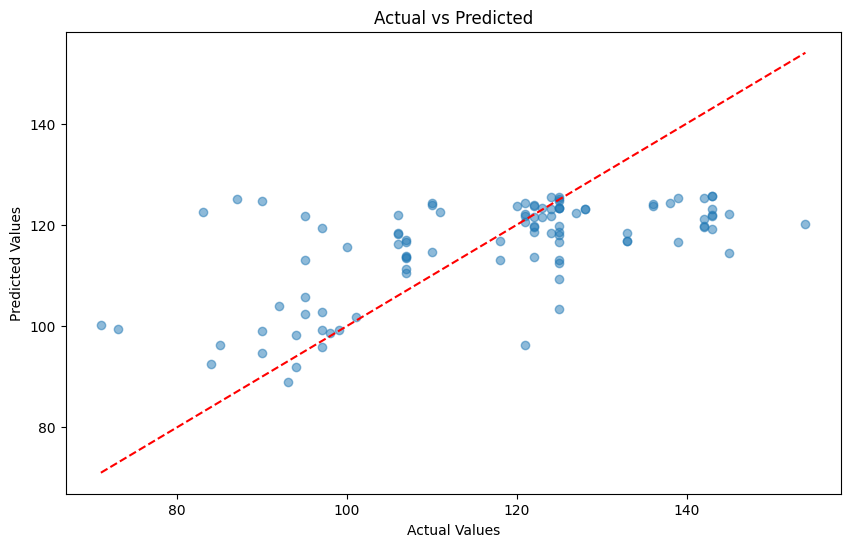

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

predy = model.predict(X_test_sbp)

# 평가 지표 계산
mse = mean_squared_error(y_test_sbp, predy)
mae = mean_absolute_error(y_test_sbp, predy)
r2 = r2_score(y_test_sbp, predy)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

# 실제값과 예측값 비교 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test_sbp, predy, alpha=0.5)
plt.plot([y_test_sbp.min(), y_test_sbp.max()], [y_test_sbp.min(), y_test_sbp.max()], 'r--')  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()

In [25]:
n_timesteps,n_features,n_outputs= X_train_dbp.shape[1],X_train_dbp.shape[2],y_train_dbp.shape[1]

In [26]:
"""
## Train and evaluate
"""

input_shape = X_train_dbp.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 875)]           0         []                            
                                                                                                  
 multi_head_attention_4 (Mu  (None, 200, 875)             3587947   ['input_2[0][0]',             
 ltiHeadAttention)                                                   'input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 200, 875)             0         ['multi_head_attention_4[0][0]
                                                                    ']                            
                                                                                            

 conv1d_13 (Conv1D)          (None, 200, 875)             4375      ['dropout_14[0][0]']          
                                                                                                  
 layer_normalization_13 (La  (None, 200, 875)             1750      ['conv1d_13[0][0]']           
 yerNormalization)                                                                                
                                                                                                  
 tf.__operators__.add_13 (T  (None, 200, 875)             0         ['layer_normalization_13[0][0]
 FOpLambda)                                                         ',                            
                                                                     'tf.__operators__.add_12[0][0
                                                                    ]']                           
                                                                                                  
 multi_hea

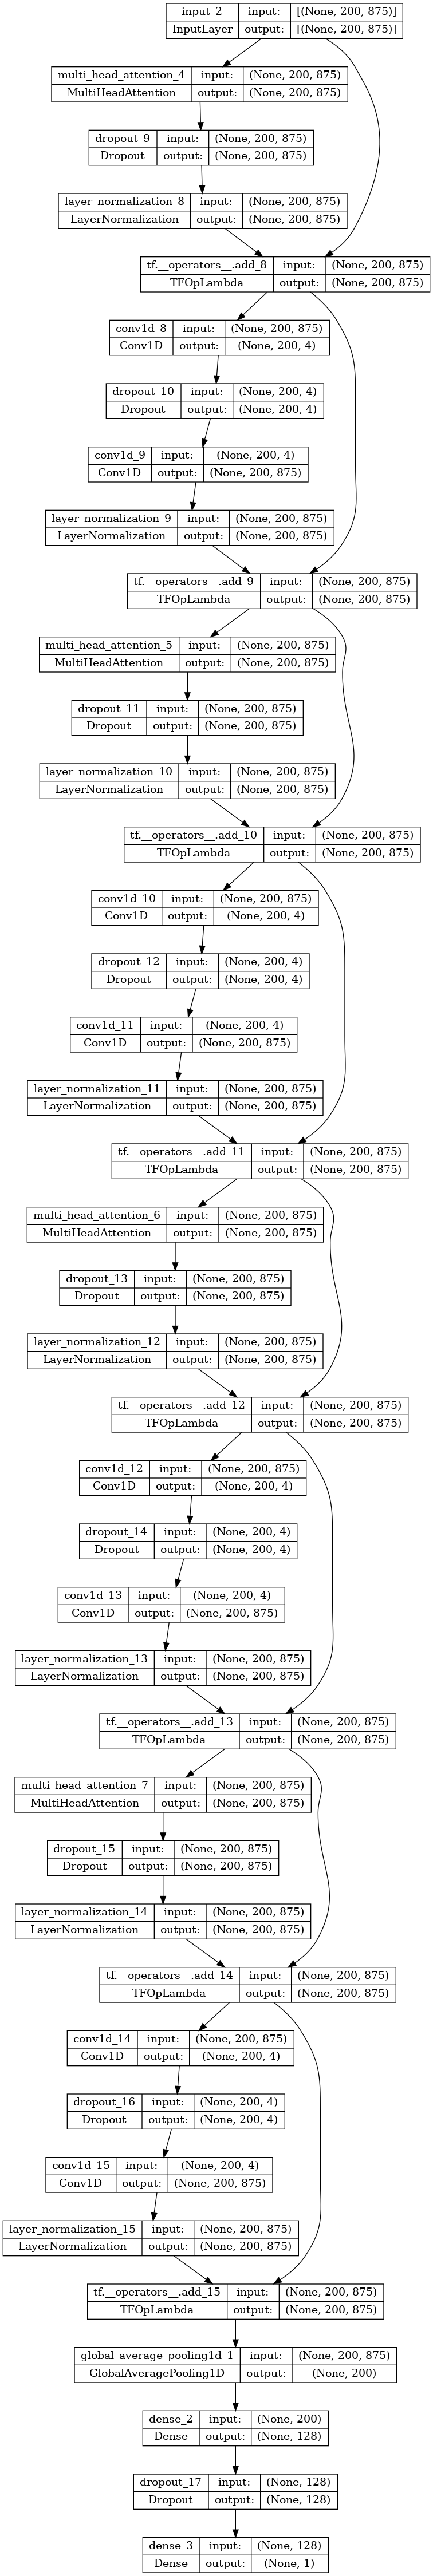

In [27]:
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [28]:
history = model.fit(
    X_train_dbp,
    y_train_dbp,
    validation_data=(X_val_dbp, y_val_dbp),
    epochs=300,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(X_test_dbp, y_test_dbp, verbose=1)

Epoch 1/300
5/5 [==============================] - 10s 245ms/step - loss: 3516.2117 - mean_squared_error: 3516.2117 - val_loss: 3598.1968 - val_mean_squared_error: 3598.1968
Epoch 2/300
5/5 [==============================] - 1s 106ms/step - loss: 3513.3889 - mean_squared_error: 3513.3889 - val_loss: 3594.3677 - val_mean_squared_error: 3594.3677
Epoch 3/300
5/5 [==============================] - 1s 108ms/step - loss: 3509.2690 - mean_squared_error: 3509.2690 - val_loss: 3589.0415 - val_mean_squared_error: 3589.0415
Epoch 4/300
5/5 [==============================] - 0s 105ms/step - loss: 3503.7913 - mean_squared_error: 3503.7913 - val_loss: 3581.9663 - val_mean_squared_error: 3581.9663
Epoch 5/300
5/5 [==============================] - 0s 103ms/step - loss: 3496.6914 - mean_squared_error: 3496.6914 - val_loss: 3572.8950 - val_mean_squared_error: 3572.8950
Epoch 6/300
5/5 [==============================] - 1s 115ms/step - loss: 3486.9541 - mean_squared_error: 3486.9541 - val_loss: 3561.60

5/5 [==============================] - 1s 117ms/step - loss: 1008.9053 - mean_squared_error: 1008.9053 - val_loss: 930.3655 - val_mean_squared_error: 930.3655
Epoch 49/300
5/5 [==============================] - 1s 118ms/step - loss: 930.7779 - mean_squared_error: 930.7779 - val_loss: 858.2080 - val_mean_squared_error: 858.2080
Epoch 50/300
5/5 [==============================] - 1s 118ms/step - loss: 855.5263 - mean_squared_error: 855.5263 - val_loss: 789.6771 - val_mean_squared_error: 789.6771
Epoch 51/300
5/5 [==============================] - 1s 116ms/step - loss: 809.5475 - mean_squared_error: 809.5475 - val_loss: 723.5712 - val_mean_squared_error: 723.5712
Epoch 52/300
5/5 [==============================] - 1s 115ms/step - loss: 741.0678 - mean_squared_error: 741.0678 - val_loss: 660.1540 - val_mean_squared_error: 660.1540
Epoch 53/300
5/5 [==============================] - 1s 111ms/step - loss: 650.9751 - mean_squared_error: 650.9751 - val_loss: 601.0151 - val_mean_squared_error: 

5/5 [==============================] - 1s 107ms/step - loss: 79.1085 - mean_squared_error: 79.1085 - val_loss: 22.5570 - val_mean_squared_error: 22.5570
Epoch 97/300
5/5 [==============================] - 0s 104ms/step - loss: 82.8656 - mean_squared_error: 82.8656 - val_loss: 21.7098 - val_mean_squared_error: 21.7098
Epoch 98/300
5/5 [==============================] - 0s 100ms/step - loss: 79.7164 - mean_squared_error: 79.7164 - val_loss: 22.5956 - val_mean_squared_error: 22.5956
Epoch 99/300
5/5 [==============================] - 0s 97ms/step - loss: 76.3193 - mean_squared_error: 76.3193 - val_loss: 22.4213 - val_mean_squared_error: 22.4213
Epoch 100/300
5/5 [==============================] - 0s 104ms/step - loss: 77.9594 - mean_squared_error: 77.9594 - val_loss: 18.8970 - val_mean_squared_error: 18.8970
Epoch 101/300
5/5 [==============================] - 0s 98ms/step - loss: 82.7584 - mean_squared_error: 82.7584 - val_loss: 19.1837 - val_mean_squared_error: 19.1837
Epoch 102/300
5/5

[18.1777400970459, 18.1777400970459]

In [29]:
# validation_split = 0.1
batch_size = 32

train_epochs = 20
history = model.fit(X_train_dbp, y_train_dbp, epochs=train_epochs, batch_size=batch_size, verbose=True, validation_data = (X_val_dbp, y_val_dbp), shuffle=True)

Epoch 1/20
10/10 [==============================] - 1s 82ms/step - loss: 64.2661 - mean_squared_error: 64.2661 - val_loss: 14.0043 - val_mean_squared_error: 14.0043
Epoch 2/20
10/10 [==============================] - 1s 52ms/step - loss: 65.1856 - mean_squared_error: 65.1856 - val_loss: 14.0804 - val_mean_squared_error: 14.0804
Epoch 3/20
10/10 [==============================] - 1s 54ms/step - loss: 61.9722 - mean_squared_error: 61.9722 - val_loss: 22.9512 - val_mean_squared_error: 22.9512
Epoch 4/20
10/10 [==============================] - 0s 51ms/step - loss: 69.7810 - mean_squared_error: 69.7810 - val_loss: 15.7293 - val_mean_squared_error: 15.7293
Epoch 5/20
10/10 [==============================] - 0s 49ms/step - loss: 66.8435 - mean_squared_error: 66.8435 - val_loss: 14.1595 - val_mean_squared_error: 14.1595
Epoch 6/20
10/10 [==============================] - 0s 49ms/step - loss: 75.6842 - mean_squared_error: 75.6842 - val_loss: 16.5853 - val_mean_squared_error: 16.5853
Epoch 7/20

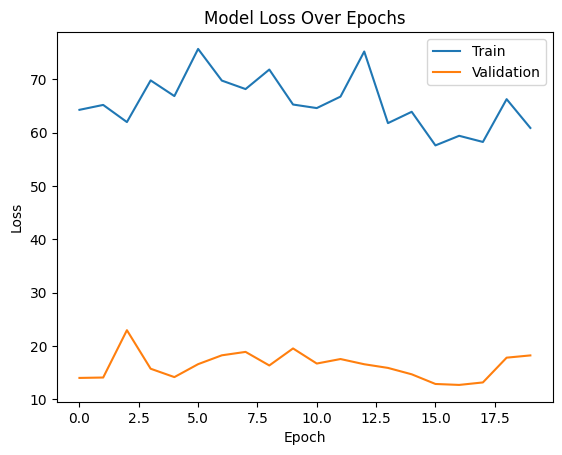

In [30]:
# 학습 손실 (Training Loss)
plt.plot(history.history['loss'])
# 검증 손실 (Validation Loss)
plt.plot(history.history['val_loss'])

# 그래프 제목 및 축 레이블 설정
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# 범례 추가
plt.legend(['Train', 'Validation'], loc='upper right')

# 그래프 출력
plt.show()

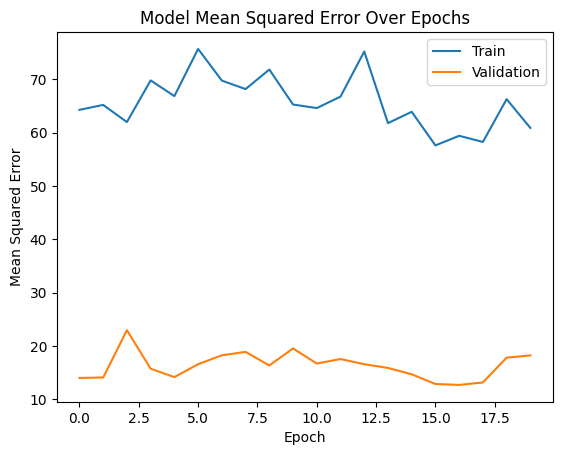

In [31]:
# 학습 손실 (Training Loss: Mean Squared Error)
plt.plot(history.history['mean_squared_error'])
# 검증 손실 (Validation Loss: Mean Squared Error)
plt.plot(history.history['val_mean_squared_error'])

# 그래프 제목 및 축 레이블 설정
plt.title('Model Mean Squared Error Over Epochs')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')

# 범례 추가
plt.legend(['Train', 'Validation'], loc='upper right')

# 그래프 출력
plt.show()

4/4 [==============================] - 1s 13ms/step
Mean Squared Error (MSE): 37.407909348036306
Mean Absolute Error (MAE): 4.457641871288569
R-squared (R²): 0.5228828877279574


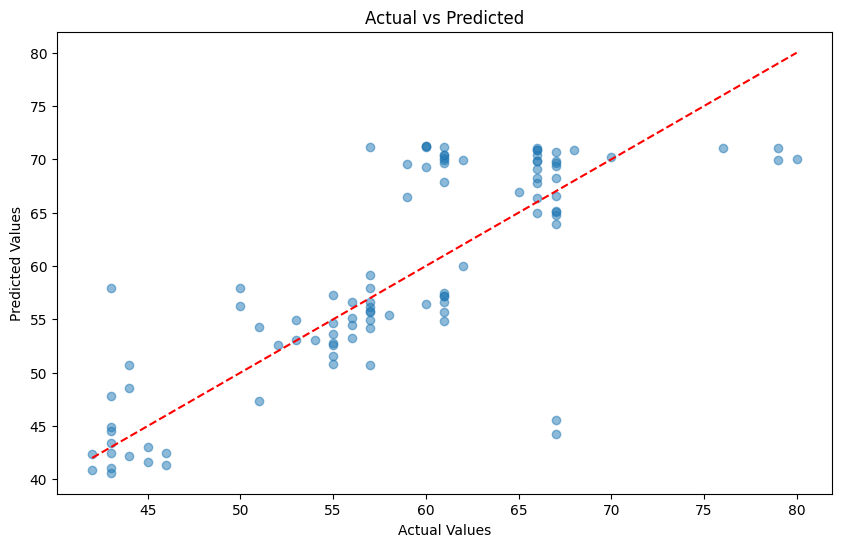

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

predy = model.predict(X_test_dbp)

# 평가 지표 계산
mse = mean_squared_error(y_test_dbp, predy)
mae = mean_absolute_error(y_test_dbp, predy)
r2 = r2_score(y_test_dbp, predy)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

# 실제값과 예측값 비교 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test_dbp, predy, alpha=0.5)
plt.plot([y_test_dbp.min(), y_test_dbp.max()], [y_test_dbp.min(), y_test_dbp.max()], 'r--')  # y=x 선
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()